In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split, Subset, ConcatDataset
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
# Set random seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)  # For CPU
    torch.cuda.manual_seed_all(seed)  # For all GPUs
    np.random.seed(seed)  # For NumPy
    random.seed(seed)  # For Python random
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
seed = 42
set_seed(seed)

# Mean and standard deviation for normalization (CIFAR-10 specific)
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

# Transformations for the training set (includes data augmentation)
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.6),   # Horizontal flip with probability 0.5
    transforms.RandomCrop(32, padding=4),     # Random crop with padding of 4 pixels
    transforms.RandomRotation(15),           # Random rotation of ±15 degrees
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Uncomment if needed
    transforms.ToTensor(),                    # Convert image to tensor
    transforms.Normalize(mean, std)          # Normalize with mean and std
])
# Transformations for the validation and test set (no data augmentation)
test_transforms = transforms.Compose([
    transforms.ToTensor(),                    # Convert image to tensor
    transforms.Normalize(mean, std)          # Normalize with mean and std
])
# Load CIFAR-10 training dataset both augmented and not augmented
dataset_augmented = CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
dataset_normal = CIFAR10(root='./data', train=True, download=True, transform=test_transforms)

# Step 3: Suddividere il dataset in Train (80%) e Validation (20%)
train_size = int(0.8 * len(dataset_augmented))  # 80% dei dati
val_size = len(dataset_augmented) - train_size  # 20% dei dati
train_dataset, val_dataset = random_split(dataset_augmented, [train_size, val_size], generator=torch.Generator().manual_seed(seed))
# take validation indices for not augmented dataset
val_dataset = Subset(dataset_normal, val_dataset.indices)
# Load CIFAR-10 dataset for testing
test_dataset = CIFAR10(
    root='./data', train=False, transform=test_transforms, download=True
)
# DataLoader for the training set
train_loader = DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=2
)
# DataLoader for the validation set
val_loader = DataLoader(
    val_dataset, batch_size=128, shuffle=False, num_workers=2
)
# DataLoader for the test set
test_loader = DataLoader(
    test_dataset, batch_size=128, shuffle=False, num_workers=2
)
# Output the dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Val set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Training set size: 40000
Val set size: 10000
Test set size: 10000


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Dropout to be set
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=drop_rate)  # first dropout added
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)  # dropout after Relu
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Layers
        self.layer1 = self._make_layer(block, 64, num_blocks[0])
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
        nn.Dropout(p=drop_rate),  # second dropout before fc
        nn.Linear(512, num_classes)
        )

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_planes, out_channels, stride))
        self.in_planes = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)
def ResNet34(num_classes=10):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)

# Dropout=0.1

In [5]:
drop_rate=0.1
resnet18_from_scratch = ResNet18(num_classes=10) 
model = resnet18_from_scratch.to(device) 
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification tasks
optimizer = optim.Adam(model.parameters())  # Adam optimizer for model parameters

# Training and validation functions
def train(model, loader, criterion, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to device (GPU/CPU)
        optimizer.zero_grad()  # Zero the gradients from the previous step
        outputs = model(inputs)  # Forward pass through the model
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters

        total_loss += loss.item()  # Accumulate the loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
            outputs = model(inputs)  # Forward pass through the model
            loss = criterion(outputs, targets)  # Compute the loss

            total_loss += loss.item()  # Accumulate the loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50  # Set the number of epochs
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Train the model
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    # Validate the model
    val_loss, val_acc = validate(model, val_loader, criterion)
    
    # Record the loss and accuracy for each epoch
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print the results for the current epoch
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(model.state_dict(), "softmax_01.pth")


Epoch 1/50:
Train Loss: 1.5389, Train Acc: 43.28%
Val Loss: 1.4742, Val Acc: 49.51%
Epoch 2/50:
Train Loss: 1.1892, Train Acc: 57.56%
Val Loss: 1.1829, Val Acc: 58.92%
Epoch 3/50:
Train Loss: 1.0289, Train Acc: 63.59%
Val Loss: 1.1356, Val Acc: 61.95%
Epoch 4/50:
Train Loss: 0.9159, Train Acc: 67.83%
Val Loss: 0.8276, Val Acc: 70.60%
Epoch 5/50:
Train Loss: 0.8332, Train Acc: 70.69%
Val Loss: 0.7291, Val Acc: 74.87%
Epoch 6/50:
Train Loss: 0.7704, Train Acc: 73.03%
Val Loss: 0.7096, Val Acc: 75.88%
Epoch 7/50:
Train Loss: 0.7243, Train Acc: 74.82%
Val Loss: 0.7417, Val Acc: 75.04%
Epoch 8/50:
Train Loss: 0.6814, Train Acc: 76.50%
Val Loss: 0.6894, Val Acc: 77.34%
Epoch 9/50:
Train Loss: 0.6430, Train Acc: 77.57%
Val Loss: 0.5830, Val Acc: 80.16%
Epoch 10/50:
Train Loss: 0.6182, Train Acc: 78.56%
Val Loss: 0.5770, Val Acc: 80.47%
Epoch 11/50:
Train Loss: 0.5862, Train Acc: 79.68%
Val Loss: 0.5490, Val Acc: 81.26%
Epoch 12/50:
Train Loss: 0.5631, Train Acc: 80.36%
Val Loss: 0.4939, Val A

In [6]:
# Results on Test Set
test_loss, test_acc = validate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")


Test Loss: 0.4105, Test Accuracy: 88.04%


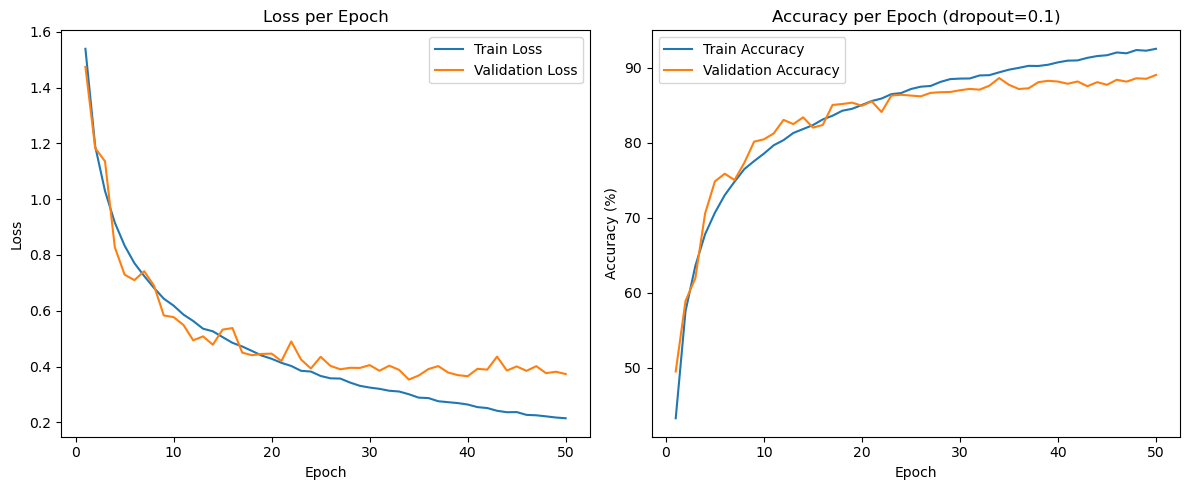

In [7]:
# Metrics plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch (dropout=0.1)")
plt.legend()

plt.tight_layout()
plt.show()

# Dropout=0.15

In [8]:
drop_rate=0.15
resnet18_from_scratch = ResNet18(num_classes=10) 
model = resnet18_from_scratch.to(device) 
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification tasks
optimizer = optim.Adam(model.parameters())  # Adam optimizer for model parameters

# Training and validation functions
def train(model, loader, criterion, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to device (GPU/CPU)
        optimizer.zero_grad()  # Zero the gradients from the previous step
        outputs = model(inputs)  # Forward pass through the model
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters

        total_loss += loss.item()  # Accumulate the loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
            outputs = model(inputs)  # Forward pass through the model
            loss = criterion(outputs, targets)  # Compute the loss

            total_loss += loss.item()  # Accumulate the loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50  # Set the number of epochs
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Train the model
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    # Validate the model
    val_loss, val_acc = validate(model, val_loader, criterion)
    
    # Record the loss and accuracy for each epoch
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print the results for the current epoch
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(model.state_dict(), "softmax_015.pth")


Epoch 1/50:
Train Loss: 1.5504, Train Acc: 43.37%
Val Loss: 1.3054, Val Acc: 55.27%
Epoch 2/50:
Train Loss: 1.2103, Train Acc: 56.49%
Val Loss: 1.1880, Val Acc: 60.43%
Epoch 3/50:
Train Loss: 1.0676, Train Acc: 62.07%
Val Loss: 1.0188, Val Acc: 64.54%
Epoch 4/50:
Train Loss: 0.9444, Train Acc: 67.00%
Val Loss: 0.7791, Val Acc: 73.63%
Epoch 5/50:
Train Loss: 0.8582, Train Acc: 70.08%
Val Loss: 0.7735, Val Acc: 72.94%
Epoch 6/50:
Train Loss: 0.7894, Train Acc: 72.44%
Val Loss: 0.7153, Val Acc: 75.52%
Epoch 7/50:
Train Loss: 0.7471, Train Acc: 73.87%
Val Loss: 0.7155, Val Acc: 75.47%
Epoch 8/50:
Train Loss: 0.7024, Train Acc: 75.55%
Val Loss: 0.6703, Val Acc: 77.11%
Epoch 9/50:
Train Loss: 0.6579, Train Acc: 77.28%
Val Loss: 0.6268, Val Acc: 78.26%
Epoch 10/50:
Train Loss: 0.6316, Train Acc: 78.03%
Val Loss: 0.5867, Val Acc: 80.46%
Epoch 11/50:
Train Loss: 0.6050, Train Acc: 79.19%
Val Loss: 0.5710, Val Acc: 80.74%
Epoch 12/50:
Train Loss: 0.5782, Train Acc: 80.14%
Val Loss: 0.4873, Val A

In [9]:
# Results on Test Set
test_loss, test_acc = validate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.4065, Test Accuracy: 87.91%


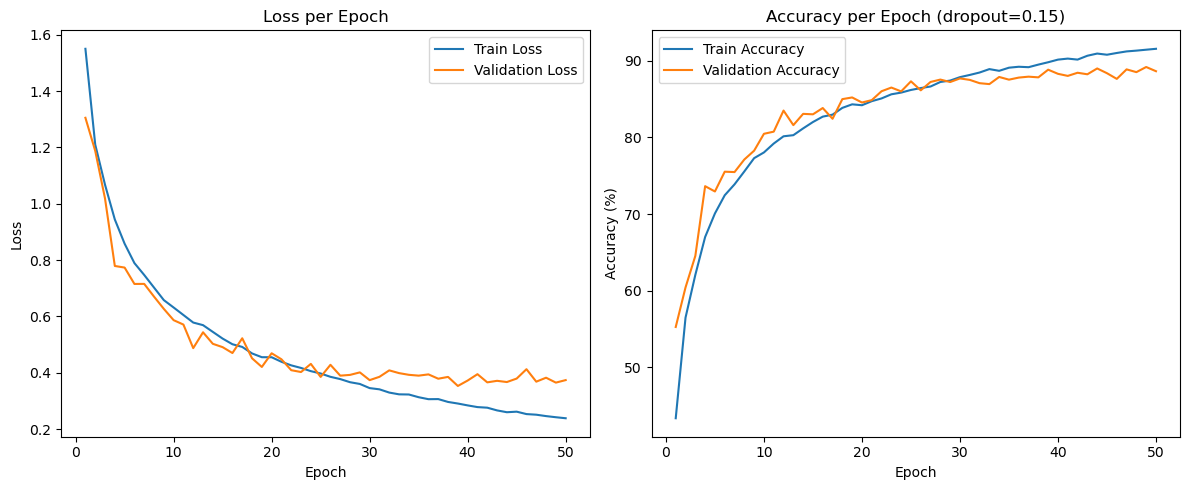

In [10]:
# Metrics plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch (dropout=0.15)")
plt.legend()

plt.tight_layout()
plt.show()

# Dropout=0.2

In [11]:
drop_rate=0.2
resnet18_from_scratch = ResNet18(num_classes=10) 
model = resnet18_from_scratch.to(device) 
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification tasks
optimizer = optim.Adam(model.parameters())  # Adam optimizer for model parameters

# Training and validation functions
def train(model, loader, criterion, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to device (GPU/CPU)
        optimizer.zero_grad()  # Zero the gradients from the previous step
        outputs = model(inputs)  # Forward pass through the model
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters

        total_loss += loss.item()  # Accumulate the loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
            outputs = model(inputs)  # Forward pass through the model
            loss = criterion(outputs, targets)  # Compute the loss

            total_loss += loss.item()  # Accumulate the loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50  # Set the number of epochs
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Train the model
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    # Validate the model
    val_loss, val_acc = validate(model, val_loader, criterion)
    
    # Record the loss and accuracy for each epoch
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print the results for the current epoch
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(model.state_dict(), "softmax_02.pth")


Epoch 1/50:
Train Loss: 1.5783, Train Acc: 41.50%
Val Loss: 1.3887, Val Acc: 50.22%
Epoch 2/50:
Train Loss: 1.2265, Train Acc: 55.69%
Val Loss: 1.0607, Val Acc: 62.39%
Epoch 3/50:
Train Loss: 1.0774, Train Acc: 61.75%
Val Loss: 1.0846, Val Acc: 63.72%
Epoch 4/50:
Train Loss: 0.9752, Train Acc: 65.58%
Val Loss: 0.7918, Val Acc: 72.32%
Epoch 5/50:
Train Loss: 0.8982, Train Acc: 68.49%
Val Loss: 0.8150, Val Acc: 71.63%
Epoch 6/50:
Train Loss: 0.8191, Train Acc: 71.58%
Val Loss: 0.7753, Val Acc: 73.60%
Epoch 7/50:
Train Loss: 0.7752, Train Acc: 72.98%
Val Loss: 0.6629, Val Acc: 77.33%
Epoch 8/50:
Train Loss: 0.7284, Train Acc: 74.50%
Val Loss: 0.6525, Val Acc: 77.63%
Epoch 9/50:
Train Loss: 0.6891, Train Acc: 75.96%
Val Loss: 0.6379, Val Acc: 78.00%
Epoch 10/50:
Train Loss: 0.6558, Train Acc: 77.14%
Val Loss: 0.5807, Val Acc: 79.93%
Epoch 11/50:
Train Loss: 0.6272, Train Acc: 78.20%
Val Loss: 0.5328, Val Acc: 81.95%
Epoch 12/50:
Train Loss: 0.6029, Train Acc: 79.03%
Val Loss: 0.5343, Val A

In [12]:
# Results on Test Set
test_loss, test_acc = validate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.3946, Test Accuracy: 87.76%


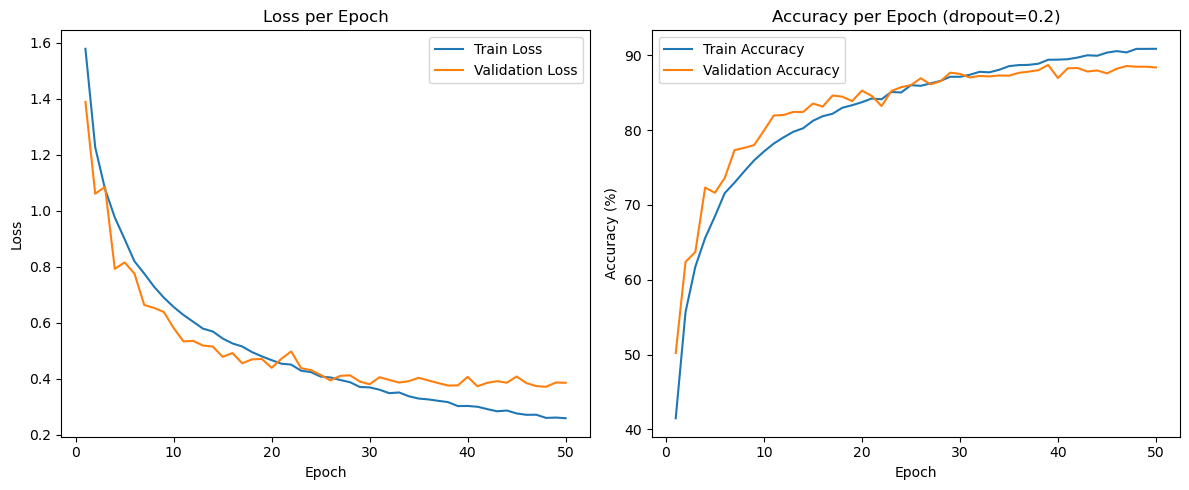

In [13]:
# Metrics plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch (dropout=0.2)")
plt.legend()

plt.tight_layout()
plt.show()

# Dropout=0.25

In [14]:
drop_rate=0.25
resnet18_from_scratch = ResNet18(num_classes=10) 
model = resnet18_from_scratch.to(device) 
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification tasks
optimizer = optim.Adam(model.parameters())  # Adam optimizer for model parameters

# Training and validation functions
def train(model, loader, criterion, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to device (GPU/CPU)
        optimizer.zero_grad()  # Zero the gradients from the previous step
        outputs = model(inputs)  # Forward pass through the model
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters

        total_loss += loss.item()  # Accumulate the loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
            outputs = model(inputs)  # Forward pass through the model
            loss = criterion(outputs, targets)  # Compute the loss

            total_loss += loss.item()  # Accumulate the loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50  # Set the number of epochs
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Train the model
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    # Validate the model
    val_loss, val_acc = validate(model, val_loader, criterion)
    
    # Record the loss and accuracy for each epoch
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print the results for the current epoch
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(model.state_dict(), "softmax_025.pth")


Epoch 1/50:
Train Loss: 1.5833, Train Acc: 41.52%
Val Loss: 1.3014, Val Acc: 53.55%
Epoch 2/50:
Train Loss: 1.2363, Train Acc: 55.67%
Val Loss: 1.0691, Val Acc: 62.08%
Epoch 3/50:
Train Loss: 1.0884, Train Acc: 61.18%
Val Loss: 1.0801, Val Acc: 63.07%
Epoch 4/50:
Train Loss: 0.9855, Train Acc: 65.30%
Val Loss: 0.8452, Val Acc: 70.67%
Epoch 5/50:
Train Loss: 0.8994, Train Acc: 68.73%
Val Loss: 0.7907, Val Acc: 72.36%
Epoch 6/50:
Train Loss: 0.8370, Train Acc: 70.83%
Val Loss: 0.7518, Val Acc: 73.92%
Epoch 7/50:
Train Loss: 0.7784, Train Acc: 73.11%
Val Loss: 0.6733, Val Acc: 76.44%
Epoch 8/50:
Train Loss: 0.7424, Train Acc: 73.99%
Val Loss: 0.6235, Val Acc: 77.95%
Epoch 9/50:
Train Loss: 0.6952, Train Acc: 76.03%
Val Loss: 0.5948, Val Acc: 79.64%
Epoch 10/50:
Train Loss: 0.6672, Train Acc: 76.81%
Val Loss: 0.5474, Val Acc: 81.04%
Epoch 11/50:
Train Loss: 0.6428, Train Acc: 77.96%
Val Loss: 0.5721, Val Acc: 80.13%
Epoch 12/50:
Train Loss: 0.6235, Train Acc: 78.52%
Val Loss: 0.5556, Val A

In [15]:
# Results on Test Set
test_loss, test_acc = validate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.3837, Test Accuracy: 88.22%


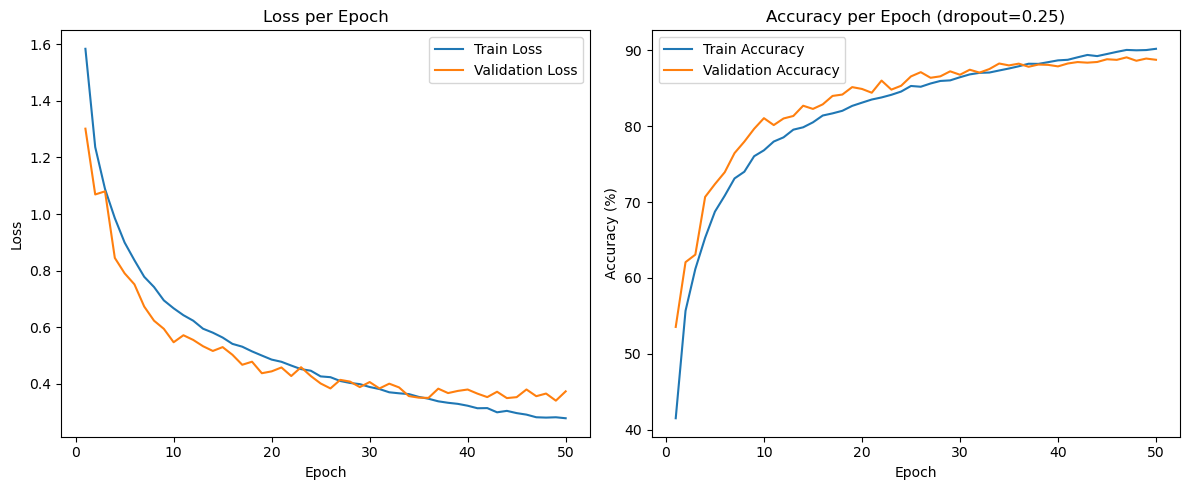

In [16]:
# Metrics plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch (dropout=0.25)")
plt.legend()

plt.tight_layout()
plt.show()

# Dropout=0.30

In [17]:
drop_rate=0.3
resnet18_from_scratch = ResNet18(num_classes=10) 
model = resnet18_from_scratch.to(device) 
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification tasks
optimizer = optim.Adam(model.parameters())  # Adam optimizer for model parameters

# Training and validation functions
def train(model, loader, criterion, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to device (GPU/CPU)
        optimizer.zero_grad()  # Zero the gradients from the previous step
        outputs = model(inputs)  # Forward pass through the model
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters

        total_loss += loss.item()  # Accumulate the loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
            outputs = model(inputs)  # Forward pass through the model
            loss = criterion(outputs, targets)  # Compute the loss

            total_loss += loss.item()  # Accumulate the loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50  # Set the number of epochs
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Train the model
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    # Validate the model
    val_loss, val_acc = validate(model, val_loader, criterion)
    
    # Record the loss and accuracy for each epoch
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print the results for the current epoch
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(model.state_dict(), "softmax_03.pth")


Epoch 1/50:
Train Loss: 1.6025, Train Acc: 40.85%
Val Loss: 1.3539, Val Acc: 51.67%
Epoch 2/50:
Train Loss: 1.2605, Train Acc: 54.63%
Val Loss: 1.0993, Val Acc: 61.12%
Epoch 3/50:
Train Loss: 1.1049, Train Acc: 60.63%
Val Loss: 1.0205, Val Acc: 64.81%
Epoch 4/50:
Train Loss: 0.9961, Train Acc: 64.78%
Val Loss: 0.8470, Val Acc: 70.25%
Epoch 5/50:
Train Loss: 0.9072, Train Acc: 68.10%
Val Loss: 0.8332, Val Acc: 71.19%
Epoch 6/50:
Train Loss: 0.8425, Train Acc: 70.53%
Val Loss: 0.8172, Val Acc: 71.93%
Epoch 7/50:
Train Loss: 0.7938, Train Acc: 72.54%
Val Loss: 0.6554, Val Acc: 77.37%
Epoch 8/50:
Train Loss: 0.7489, Train Acc: 74.03%
Val Loss: 0.5887, Val Acc: 79.27%
Epoch 9/50:
Train Loss: 0.7167, Train Acc: 75.15%
Val Loss: 0.6189, Val Acc: 78.59%
Epoch 10/50:
Train Loss: 0.6833, Train Acc: 76.39%
Val Loss: 0.5859, Val Acc: 80.29%
Epoch 11/50:
Train Loss: 0.6578, Train Acc: 76.93%
Val Loss: 0.5274, Val Acc: 81.79%
Epoch 12/50:
Train Loss: 0.6368, Train Acc: 78.13%
Val Loss: 0.5541, Val A

In [18]:
# Results on Test Set
test_loss, test_acc = validate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.3679, Test Accuracy: 88.63%


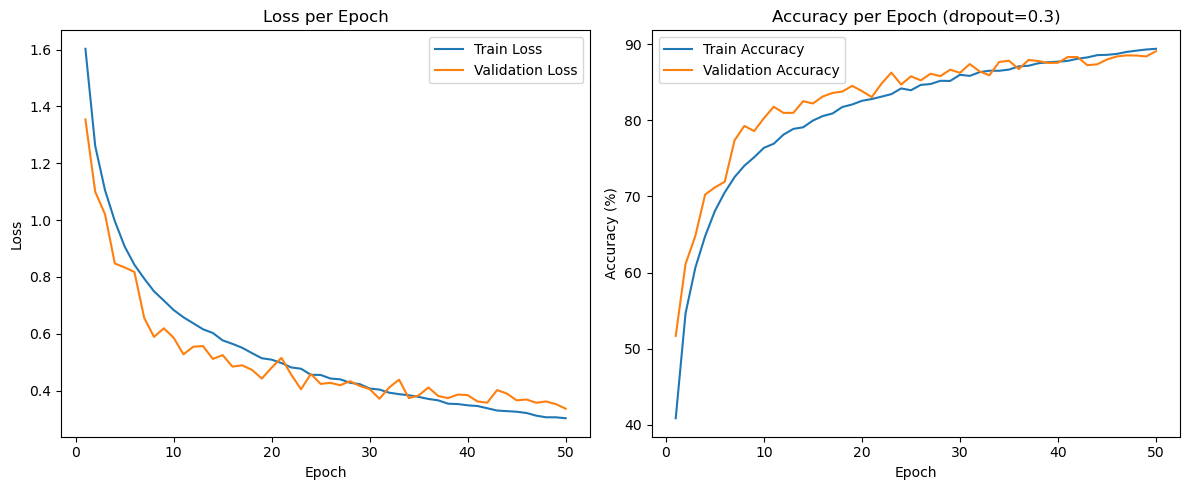

In [19]:
# Metrics plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch (dropout=0.3)")
plt.legend()

plt.tight_layout()
plt.show()